<a href="https://colab.research.google.com/github/AMEERKOTTA/hands_on_machine_learning_with_sklearn_keras_and_tensorflow/blob/main/Intro%20to%20Tensorflow%20for%20Deep%20Learning/07-Time%20Series%20Forecasting/05_forecasting_with_machine_learning_simple_linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TIME SERIES FORECASTING USING MACHINE LEARNING - SIMPLE LINEAR MODEL** 

IMPORT LIBRARIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

USEFUL FUNCTIONS

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

PREPARE THE TIME SERIES

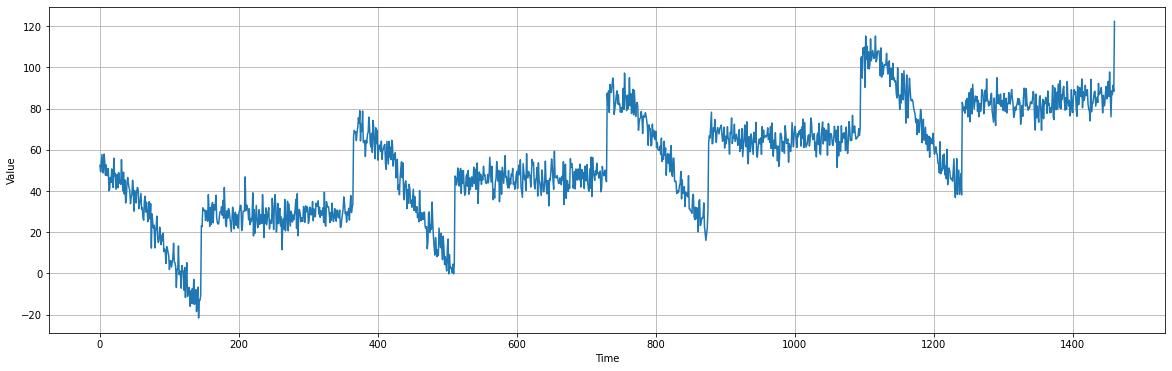

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(20, 6))
plot_series(time, series)
plt.show()

SPLIT THE DATASET

In [6]:
split_time = 1000
time_train = time[:split_time]
print(time_train.shape)
x_train = series[:split_time]
print(x_train.shape)
time_valid = time[split_time:]
print(time_valid.shape)
x_valid = series[split_time:]
print(x_valid.shape)

(1000,)
(1000,)
(461,)
(461,)


LINEAR MODEL PREPERATION

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [28]:
## prepare the dataset using window_dataset function
window_size = 30
train_set = window_dataset(x_train, window_size)
# print(train_set.shape)   ## AttributeError: 'PrefetchDataset' object has no attribute 'shape'
valid_set = window_dataset(x_valid, window_size)
# print(valid_set.shape)   ## AttributeError: 'PrefetchDataset' object has no attribute 'shape'

## build the linear model
model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

## compile the model
## uisng the SGD optimizer
## and the loss = "Huber"
## metrics = "mae"
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

## train the model for 100 epochs
r = model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 2s 16ms/step - loss: 13.8378 - mae: 14.3268 - val_loss: 11.8742 - val_mae: 12.3621
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 12.2853 - mae: 12.7717 - val_loss: 11.6310 - val_mae: 12.1201
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 11.6443 - mae: 12.1338 - val_loss: 10.7557 - val_mae: 11.2475
Epoch 4/100
31/31 [==============================] - 0s 9ms/step - loss: 11.0378 - mae: 11.5284 - val_loss: 11.9856 - val_mae: 12.4746
Epoch 5/100
31/31 [==============================] - 0s 9ms/step - loss: 10.5825 - mae: 11.0712 - val_loss: 10.1129 - val_mae: 10.6022
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 10.1236 - mae: 10.6103 - val_loss: 9.7470 - val_mae: 10.2365
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 9.7745 - mae: 10.2601 - val_loss: 9.2900 - val_mae: 9.7794
Epoch 8/100
31/31 [==============================] - 0s 8m

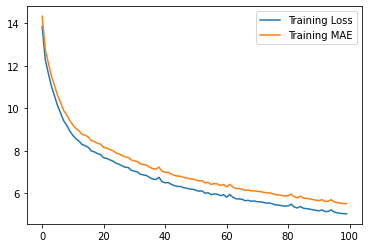

In [29]:
plt.plot(r.history["loss"], label = "Training Loss")
plt.plot(r.history["mae"], label = "Training MAE")
plt.legend();
plt.show();

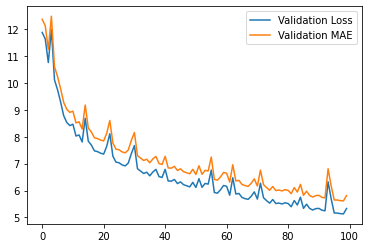

In [30]:
plt.plot(r.history["val_loss"], label = "Validation Loss")
plt.plot(r.history["val_mae"], label = "Validation MAE")
plt.legend();
plt.show();

USING LEARNING RATE SCHEDULER AS CALLBACKS

In [32]:
window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

## learning rate scheduler
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 4ms/step - loss: 119.8604 - mae: 120.3599 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 104.3806 - mae: 104.8804 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 86.2040 - mae: 86.7032 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 66.7654 - mae: 67.2651 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 45.7313 - mae: 46.2310 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 24.1783 - mae: 24.6759 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 9.0859 - mae: 9.5752 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 6ms/step - loss: 7.8088 - mae: 8.2971 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 7.6621 - mae: 8.1492 - 

(1e-06, 0.001, 0.0, 20.0)

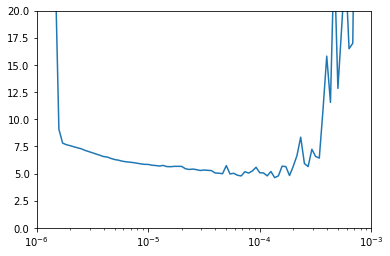

In [33]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

+ Initially, The Error decreases very Quickly.
+ Then it is decreasing slowy.
+ Then it got some jiggling effect.
+ Then it got shoot backed to 20 and more.

USING THE EARLY STOPPING METHOD

In [34]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
history = model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 13ms/step - loss: 38.8724 - mae: 39.3698 - val_loss: 23.7946 - val_mae: 24.2946
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 10.2116 - mae: 10.7030 - val_loss: 8.4656 - val_mae: 8.9538
Epoch 3/500
31/31 [==============================] - 1s 17ms/step - loss: 8.8309 - mae: 9.3186 - val_loss: 8.7899 - val_mae: 9.2780
Epoch 4/500
31/31 [==============================] - 1s 17ms/step - loss: 8.5505 - mae: 9.0386 - val_loss: 8.2573 - val_mae: 8.7459
Epoch 5/500
31/31 [==============================] - 0s 10ms/step - loss: 8.3149 - mae: 8.8004 - val_loss: 7.7353 - val_mae: 8.2200
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 8.1294 - mae: 8.6150 - val_loss: 7.6930 - val_mae: 8.1809
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 7.9396 - mae: 8.4242 - val_loss: 7.4965 - val_mae: 7.9834
Epoch 8/500
31/31 [==============================] - 0s 8ms/step - loss: 

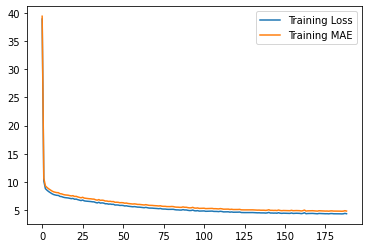

In [35]:
plt.plot(history.history["loss"], label = "Training Loss")
plt.plot(history.history["mae"], label = "Training MAE")
plt.legend();
plt.show();

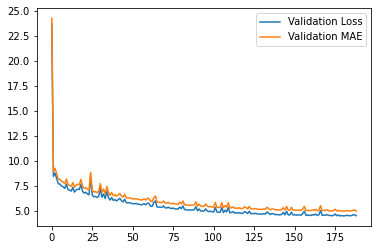

In [36]:
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.plot(history.history["val_mae"], label = "Validation MAE")
plt.legend();
plt.show();

Here Early Stopping Just interrepted the Training.

MAKE PREDICTIONS USING THE MODEL

In [37]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [38]:
lin_forecast = model_forecast(model, 
                              series[split_time - window_size:-1], 
                              window_size)[:, 0]

print(lin_forecast.shape)

15/15 [==============================] - 0s 9ms/step
(461,)


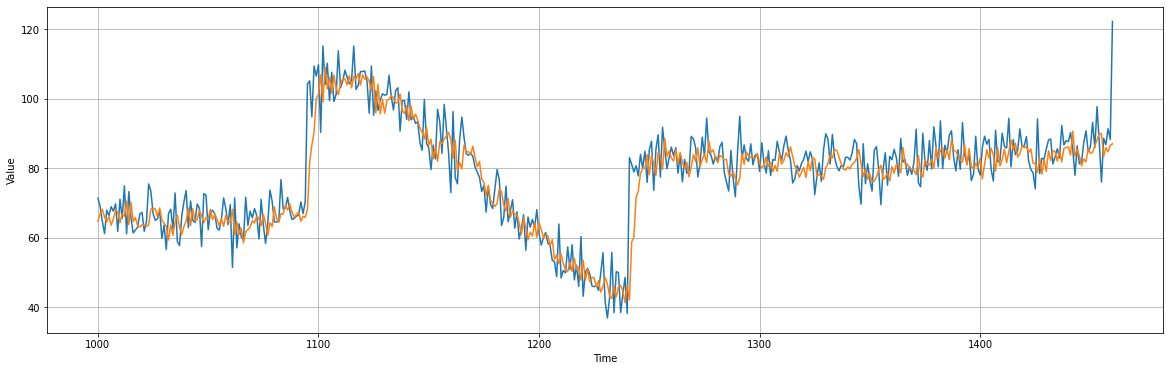

In [39]:
## plot the series and forecasts
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [40]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

4.942422

`LINEAR MODEL MAE : 4.9`

DENSE MODEL FORECASTING

In [42]:
window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 2s 14ms/step - loss: 45.3297 - mae: 45.8293 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 44.9843 - mae: 45.4839 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 3ms/step - loss: 44.5552 - mae: 45.0549 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 44.0570 - mae: 44.5567 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 43.4881 - mae: 43.9875 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 42.8242 - mae: 43.3236 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 42.0597 - mae: 42.5588 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - loss: 41.1605 - mae: 41.6599 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 6ms/step - loss: 40.1049 - mae: 40.6043

(1e-07, 0.005, 0.0, 30.0)

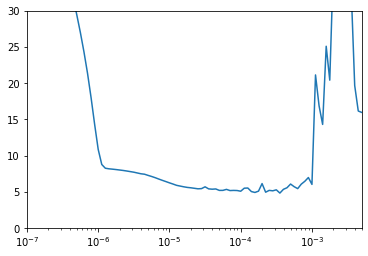

In [43]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [44]:
window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 14ms/step - loss: 11.5668 - mae: 12.0591 - val_loss: 6.2176 - val_mae: 6.7061
Epoch 2/500
31/31 [==============================] - 1s 16ms/step - loss: 6.2686 - mae: 6.7535 - val_loss: 6.6775 - val_mae: 7.1613
Epoch 3/500
31/31 [==============================] - 1s 18ms/step - loss: 6.0570 - mae: 6.5424 - val_loss: 5.9309 - val_mae: 6.4157
Epoch 4/500
31/31 [==============================] - 0s 9ms/step - loss: 5.9737 - mae: 6.4610 - val_loss: 6.0697 - val_mae: 6.5491
Epoch 5/500
31/31 [==============================] - 0s 9ms/step - loss: 5.8751 - mae: 6.3616 - val_loss: 5.6915 - val_mae: 6.1760
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 5.7729 - mae: 6.2533 - val_loss: 5.4603 - val_mae: 5.9465
Epoch 7/500
31/31 [==============================] - 0s 10ms/step - loss: 5.6965 - mae: 6.1795 - val_loss: 5.3924 - val_mae: 5.8710
Epoch 8/500
31/31 [==============================] - 0s 9ms/step - loss: 5.61

In [45]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 7ms/step


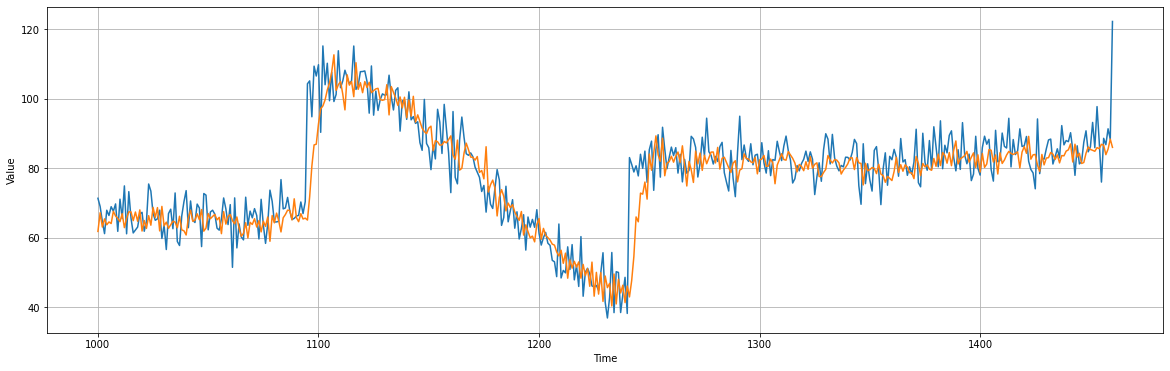

In [46]:
plt.figure(figsize=(20, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [47]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

5.270956

`SIMPLE LINEAR MODEL WITH DENSE LAYER MAE = 5.2`

***